# Moving Horizon Estimator

Simple implementation - see 12-10 for relevant equations

In [59]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

from numpy.random import randn
from numpy import eye, array, asarray, exp

from math import sqrt
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
from scipy import linalg as la
from scipy.integrate import odeint
from scipy.optimize import minimize

Running Python: 3.9.9


In [60]:
#Simulate the system
N = 100 # npts
Nx = 3 # state dim
Ny = 2 # number of outputs
Nwind = 15 # Pick an estimation window size
KK = np.arange(N+1+Nwind) # time steps 

V = 0.25  # Velocity
dt = 2 # step time
np.random.seed(10) # set for consistent results
d2r = np.pi/180

# Process noise 
Wd = np.array([[0.1**2, 0, 0],[0, 0.1**2, 0],[0, 0, (1*d2r)**2]])
# sensor noise
Rd = np.array([[0.5**2, 0],[0, (2*d2r)**2]]) # meas noises

# location of the tracking sensor
X_pos = np.array([-6, 0])

# storage 
Xsm = np.zeros((Nx,1,N+1+Nwind))

# IC 
x0 = np.array([0, 0, 90*np.pi/180]) # actual initial condition
Q0 = np.array([[2**2, 0, 0],[0, 2**2, 0],[0, 0, (5*d2r)**2]])

# storage 
Xsm = np.zeros((Nx,1,N+1+Nwind))
Y = np.zeros((Ny,1,N+1+Nwind))

In [61]:
# choose some inputs so that something interesting happens
if 1:
    Beta = 0 # linear
else:
    Beta = -20 # nonlinear

# design some inputs so something happens    
uu = 6
u = np.zeros((1,N+1+Nwind))
u[0,0:int(N/4)] = uu*d2r
u[0,int(N/4):int(N/2)] = -uu*d2r
u[0,int(N/2):int(3*N/4)] = uu*d2r
u[0,int(3*N/4):N+1+Nwind] = -uu*d2r

In [62]:
# Define the dynamics and measurement functions
def fdyn(X,u): 
    Xp1 = copy.deepcopy(X).reshape(Nx,1)
    Xp1[0] += dt * V * np.cos(Xp1[2]) 
    Xp1[1] += dt * V * np.sin(Xp1[2]) 
    Xp1[2] += dt * (u + Beta*u**3)  
    return Xp1

def hmeas(X):
    Y = np.zeros((Ny,1)).reshape(Ny,1)
    Y[0] = np.linalg.norm(X[0:2].reshape(Nx-1,1)-X_pos.reshape(Nx-1,1)) 
    Y[1] = X[2]  
    return Y

def Hmeas(X):
    r = np.linalg.norm(X[0:2].reshape(Nx-1,1)-X_pos.reshape(Nx-1,1))
    H = np.array([[(X[0]-X_pos[0])/r, (X[1]-X_pos[1])/r, 0],[0,0,1]]) 
    return H

def Lin_Ad(X):
    Ad = np.array([[1,0, -dt*V*np.sin(X[2])],[0,1,dt*V*np.cos(X[2])],[0,0,1]])
    return Ad

# callback storage
all_x_i=[]
all_y_i=[]
all_t_i=[]
def store(x):
    all_x_i.append(x[0])
    all_y_i.append(x[1])
    all_t_i.append(x[2])

In [63]:
# plotting
def plot_sols(Xopt,KK,kstart,title='Simulation'):
    plt.figure(figsize=(12,8))
    plt.subplot(311)
    plt.plot(KK[kstart:kstart+Nwind],Xopt[0,0,0:Nwind],label=r'Optimized')
    plt.plot(KK[kstart:kstart+Nwind],Xsm[0,0,kstart:kstart+Nwind],label='Actual')
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel('X')
    plt.xlim([KK[kstart],KK[kstart+Nwind]])
    plt.grid(True)
    plt.subplot(312)
    plt.plot(KK[kstart:kstart+Nwind],Xopt[1,0,0:Nwind])
    plt.plot(KK[kstart:kstart+Nwind],Xsm[1,0,kstart:kstart+Nwind])
    plt.ylabel('Y')
    plt.xlim([KK[kstart],KK[kstart+Nwind]])
    plt.grid(True)
    #plt.tight_layout
    plt.subplot(313)
    plt.plot(KK[kstart:kstart+Nwind],Xopt[2,0,0:Nwind]/d2r)
    plt.plot(KK[kstart:kstart+Nwind],Xsm[2,0,kstart:kstart+Nwind]/d2r)
    plt.ylabel(r'$\theta$')
    plt.xlabel('k')
    plt.xlim([KK[kstart],KK[kstart+Nwind]])
    plt.grid(True)
    plt.show()

## Simulate the response

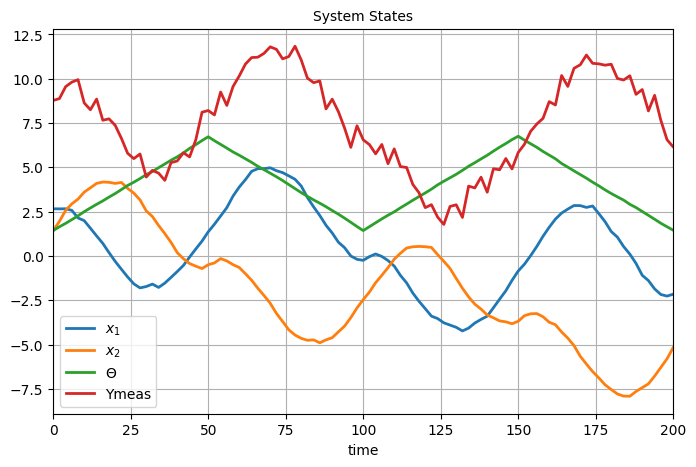

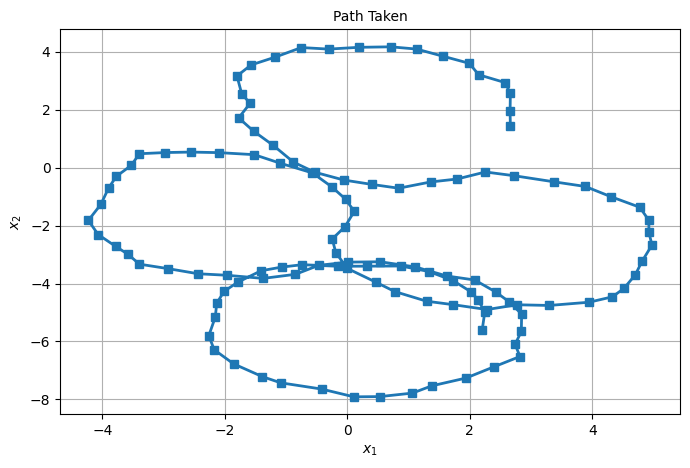

In [64]:
Xsm[:,:,0] = np.vstack(x0) + sqrtm(Q0)@np.vstack(randn(Nx)) # random initial pt

for k in KK[:-1]:
    Y[:,:,k] = hmeas(Xsm[:,:,k]) + sqrtm(Rd)@np.vstack(randn(Ny)) # meas with noise
    Xsm[:,:,k+1] = fdyn(Xsm[:,:,k],u[:,k]) + sqrtm(Wd)@np.vstack(randn(Nx))     

Y[:,:,N+Nwind] = hmeas(Xsm[:,:,N+Nwind]) + sqrtm(Rd)@np.vstack(randn(Ny)) # meas with noise
    
plt.figure(3,figsize=(8,5))
plt.plot(KK*dt,Xsm[0,0,:],label=r'$x_1$')
plt.plot(KK*dt,Xsm[1,0,:],label=r'$x_2$')
plt.plot(KK*dt,Xsm[2,0,:],label=r'$\Theta$')
plt.plot(KK*dt,Y[0,0,:],label='Ymeas')
plt.xlabel('time')
plt.xlim(0,N*dt)
plt.title('System States')
plt.legend(loc='best')
plt.show()

plt.figure(4,figsize=(8,5))
plt.plot(Xsm[0,0,:],Xsm[1,0,:],'s-')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Path Taken')
plt.show()

## Form cost functions to optimize

In [77]:
def my_MHE(Xvar,xm,Qm,k_init):
    Xest =  copy.deepcopy(Xvar[0:Nx]).reshape(Nx,1)
    x_err = Xest - xm.reshape(Nx,1)
    J = x_err.T@np.linalg.inv(np.atleast_2d(Qm))@x_err
    for k_est in np.arange(Nwind):
        V = Y[:,:,k_init+k_est] - hmeas(Xest) 
        W =  Xvar[Nx*(k_est+1):Nx*(k_est+2)].reshape(Nx,1)
        J += V.T@np.linalg.inv(np.atleast_2d(Rd))@V + W.T@np.linalg.inv(np.atleast_2d(Wd))@W
        Xest = fdyn(Xest,u[:,k_init+k_est]) + W
    return J.flatten()

# Similar calc but for simulations
def my_MHE_sim(Xvar,k_init):
    Xest =  copy.deepcopy(Xvar[0:Nx]).reshape(Nx,1)
    Xmhe = np.zeros((Nx,1,N+1))
    Xmhe[:,:,0] = copy.deepcopy(np.vstack(Xest[:]))
    for k_sim in np.arange(Nwind):
        Xest = fdyn(Xest,u[:,k_init+k_sim]) + Xvar[Nx*(k_sim+1):Nx*(k_sim+2)].reshape(Nx,1)
        Xmhe[:,:,k_sim+1] = copy.deepcopy(Xest)
    return Xmhe

def Initialize_W(x0):
    Xstart = copy.deepcopy(x0)
    for k in np.arange(Nwind):
        Xstart = np.append(Xstart,sqrtm(Wd)@np.vstack(randn(Nx)))      
    return Xstart

## Initial Simulation from initial prediction

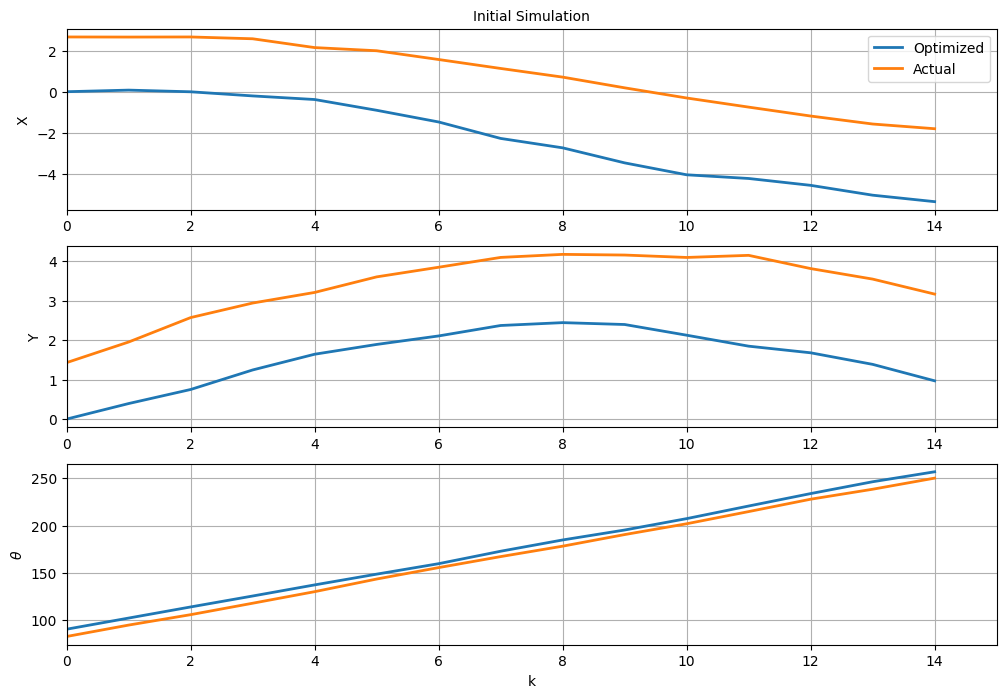

In [78]:
kstart = 0 # overall index for the start of the data window
Xstart = Initialize_W(x0)
Xpredict = my_MHE_sim(Xstart,kstart)
plot_sols(Xpredict,KK,kstart,title='Initial Simulation')

## Pose/solve Optimization Problem

In [68]:
kstart = 0
xm = copy.deepcopy(x0)
Qm = copy.deepcopy(Q0)

# initialize with our best guess of state IC and noises (random)
Xstart = Initialize_W(x0)

# callback storage
all_x_i=[]
all_y_i=[]
all_t_i=[]

store(Xstart)
tic = time.time()
Xsol0 = minimize(my_MHE, Xstart, method='BFGS',callback=store, tol=100, options={'disp': True}, args=(xm,Qm,kstart))
print('\nBFGS optimized x(0|0) value =', Xsol0.x[0:Nx])
print(f'Compute time: {time.time()-tic:6.4f}')
BFGS_sol_path=np.array([all_x_i,all_y_i,all_t_i])

Optimization terminated successfully.
         Current function value: 37.517599
         Iterations: 30
         Function evaluations: 2303
         Gradient evaluations: 47

BFGS optimized x(0|0) value = [ 1.8773  2.5433  1.4563]
3.0229


In [69]:
# Extract updated state estimate
x_00 = Xsol0.x[0:Nx].flatten()

# Compute predicted covariances using the linearized A and H
Ad0 = Lin_Ad(x_00)
H0 = Hmeas(x_00)
Q_00 = np.linalg.inv(np.linalg.inv(Q0) + H0.T@np.linalg.inv(np.atleast_2d(Rd))@H0)
Q_10 = Ad0@Q_00@Ad0.T+Wd

# Extract the estimate process noise
W0 =  Xsol0.x[Nx : 2*Nx].reshape(Nx,1)
# Use updates to predict state at next time step 
x_10 = fdyn(x_00,u[:,kstart]).flatten() + W0.flatten()

print('\nInitial State Estimate at x(0) =', x0.T)
print('Updated State Estimate at x(0|0) =', x_00.T)
print('\nPredicted State Estimate at x(1|0) =', x_10.T)
print('\nState Uncertainty at Q(1|0) =')
print('\n'.join([''.join(['{:8.4f}, '.format(item) for item in row]) for row in Q_10]))


Initial State Estimate at x(0) = [ 0.0000  0.0000  1.5708]
Updated State Estimate at x(0|0) = [ 1.8773  2.5433  1.4563]

Predicted State Estimate at x(1|0) = [ 2.0949  3.0868  1.6660]

State Uncertainty at Q(1|0) =
  0.6009,  -1.1008,  -0.0005, 
 -1.1008,   3.6546,   0.0001, 
 -0.0005,   0.0001,   0.0014, 


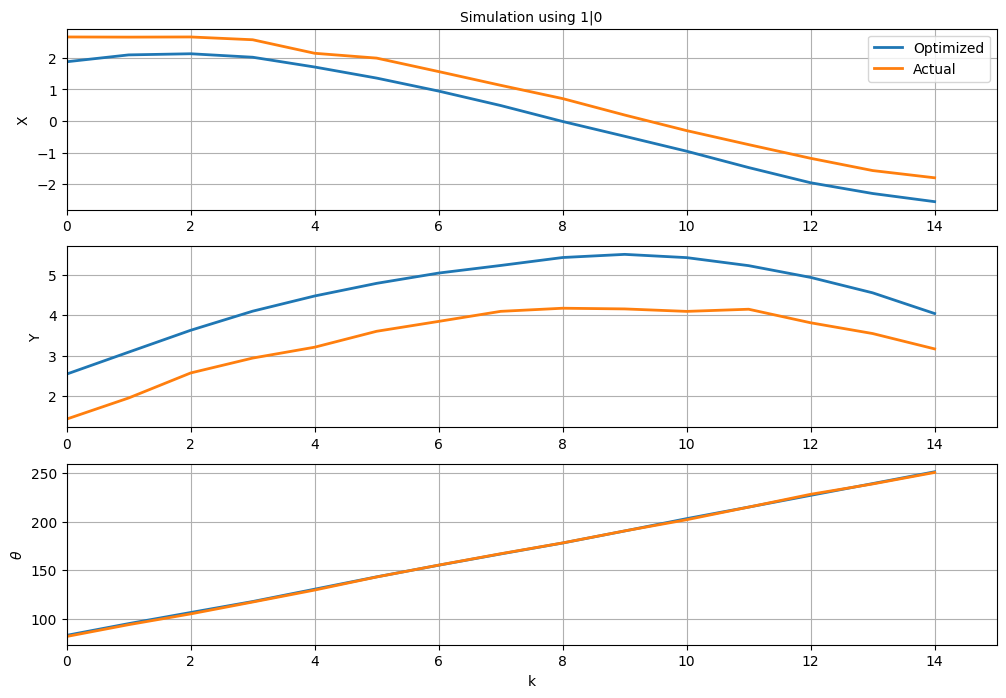

In [70]:
# See how the predicted simulations from time 0 look now compared to before 
Xopt0 = my_MHE_sim(Xsol0.x,kstart)
plot_sols(Xopt0,KK,kstart,title='Simulation using 1|0')

## Step Forward and Repeat calculation over new data

In [71]:
kstart = 1
xm = copy.deepcopy(x_10)
Qm = copy.deepcopy(Q_10)
# initial coondition is most of the previous solution
Xstart1 = np.append(np.append(np.array(x_10),Xsol0.x[2*Nx:]),sqrtm(Wd)@np.vstack(randn(Nx)))

# callback storage
all_x_i=[]
all_y_i=[]
all_t_i=[]

store(Xstart1)
Xsol1 = minimize(my_MHE, Xstart1, method='BFGS',callback=store, options={'disp': True}, args=(xm,Qm,kstart))
print('\nBFGS optimized x(1|1) value =', Xsol1.x[0:Nx])
BFGS_sol_path=np.array([all_x_i,all_y_i,all_t_i])

Optimization terminated successfully.
         Current function value: 19.222418
         Iterations: 68
         Function evaluations: 5194
         Gradient evaluations: 106

BFGS optimized x(1|1) value = [ 2.9590  1.8469  1.6469]


In [72]:
def Prop_one_step(Xsol,Q_kkm1,tkk):
    x_kk = copy.deepcopy(Xsol.x[0:Nx]).reshape(Nx,1).flatten()

    # Compute predicted covariances using the linearized A and H
    Ad = Lin_Ad(x_kk)
    H = Hmeas(x_kk)
    Q_kk = np.linalg.inv(np.linalg.inv(Q_kkm1) + H.T@np.linalg.inv(np.atleast_2d(Rd))@H)
    Q_kp1k = Ad@Q_kk@Ad.T+Wd

    # Extract the estimate process noise
    Wopt =  copy.deepcopy(Xsol.x[Nx:2*Nx]).reshape(Nx,1)
    # Use updates to predict state at next time step 
    x_kp1k = fdyn(x_kk,u[:,tkk]).flatten() + Wopt.flatten()
    return x_kp1k, Q_kp1k, Q_kk


State Estimate at x(2|1) = [ 2.9495  2.3497  1.8542]

State Uncertainty at Q(2|1) =
  0.3627,  -0.8700,  -0.0004, 
 -0.8700,   3.4503,  -0.0001, 
 -0.0004,  -0.0001,   0.0009, 


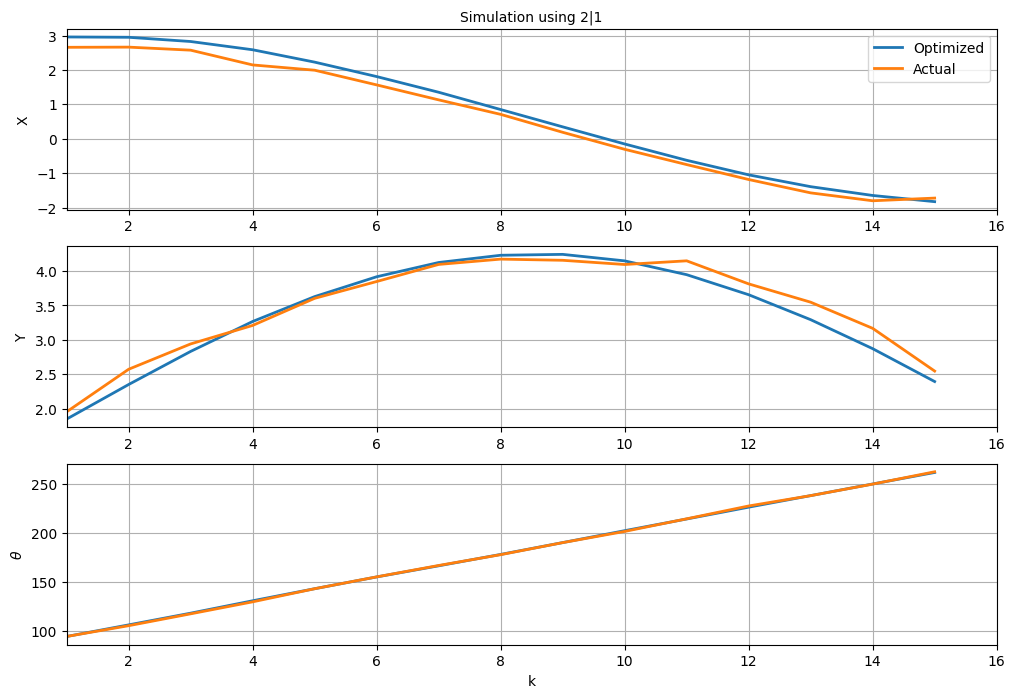

In [73]:
x_21,Q_21,_ = Prop_one_step(Xsol1,Q_10,kstart)

print('\nState Estimate at x(2|1) =', x_21.T)
print('\nState Uncertainty at Q(2|1) =')
print('\n'.join([''.join(['{:8.4f}, '.format(item) for item in row]) for row in Q_21]))

Xopt1 = my_MHE_sim(Xsol1.x,kstart) 
plot_sols(Xopt1,KK,kstart,title='Simulation using 2|1')

## Now Optimize Over All Data

In [74]:
xm = copy.deepcopy(x0)
Qm = copy.deepcopy(Q0)
Xsolk = Xsol0 # get size right
Xsolk.x = Initialize_W(xm) # replace the values

Xstore = Xsm*0 # get size right
Qstore = np.zeros((1,Nx,N))

for kk in np.arange(N):
    # initial condition is most of the previous solution
    Xstart = np.append(np.append(np.array(xm),Xsolk.x[2*Nx:]),sqrtm(Wd)@np.vstack(randn(Nx)))

    Xsolk = minimize(my_MHE, Xstart, method='BFGS', tol=100, options={'disp': False}, args=(xm,Qm,kk))
    print('BFGS optimized x('+str(kk)+') value =', Xsolk.x[0:Nx])
    BFGS_sol_path = np.array([all_x_i,all_y_i,all_t_i])

    xm, Qm, Qp = Prop_one_step(Xsolk,Qm,kk)

    # store the updated pred at a given time
    Xstore[:,:,kk] = copy.deepcopy(Xsolk.x[0:Nx]).reshape(Nx,1)
    Qstore[:,:,kk] = np.diag(Qp)

BFGS optimized x(0) value = [ 2.8508  1.3119  1.4506]
BFGS optimized x(1) value = [ 2.9519  1.8096  1.6500]
BFGS optimized x(2) value = [ 2.9322  2.3264  1.8577]
BFGS optimized x(3) value = [ 2.8160  2.8059  2.0607]
BFGS optimized x(4) value = [ 2.5933  3.2423  2.2846]
BFGS optimized x(5) value = [ 2.3032  3.3468  2.5001]
BFGS optimized x(6) value = [ 1.9035  3.6514  2.7104]
BFGS optimized x(7) value = [ 1.4641  3.8565  2.9085]
BFGS optimized x(8) value = [ 0.9783  3.9710  3.1138]
BFGS optimized x(9) value = [ 0.4893  3.9843  3.3245]
BFGS optimized x(10) value = [ 0.2267  3.3974  3.5393]
BFGS optimized x(11) value = [-0.2354  3.2003  3.7431]
BFGS optimized x(12) value = [-0.6502  2.9133  3.9530]
BFGS optimized x(13) value = [-0.9807  2.5499  4.1516]
BFGS optimized x(14) value = [-1.2297  2.1297  4.3556]
BFGS optimized x(15) value = [-1.4051  1.6532  4.5571]
BFGS optimized x(16) value = [-1.4685  1.1587  4.7573]
BFGS optimized x(17) value = [-1.4377  0.6549  4.9579]
BFGS optimized x(18)

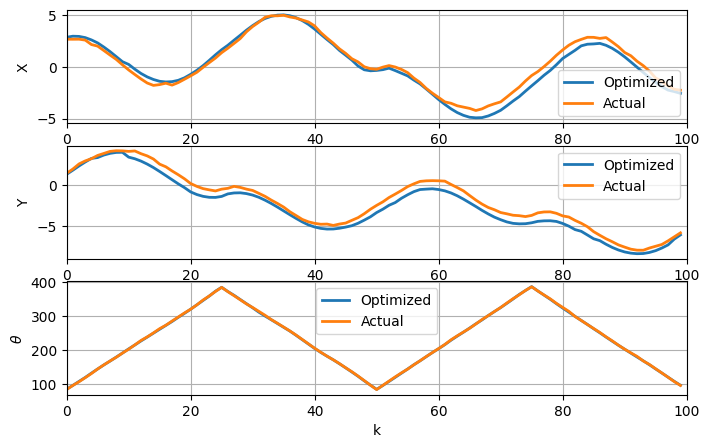

In [75]:
plt.figure(figsize=(8,5))
plt.subplot(311)
plt.plot(KK[0:N],Xstore[0,0,0:N],label=r'Optimized')
plt.plot(KK[0:N],Xsm[0,0,0:N],label='Actual')
plt.legend(loc='best')
plt.ylabel('X')
plt.xlim([0, N])
plt.grid(True)
plt.subplot(312)
plt.plot(KK[0:N],Xstore[1,0,0:N],label=r'Optimized')
plt.plot(KK[0:N],Xsm[1,0,0:N],label='Actual')
plt.legend(loc='best')
plt.ylabel('Y')
plt.xlim([0, N])
plt.grid(True)
#plt.tight_layout
plt.subplot(313)
plt.plot(KK[0:N],Xstore[2,0,0:N]/d2r,label=r'Optimized')
plt.plot(KK[0:N],Xsm[2,0,0:N]/d2r,label='Actual')
plt.ylabel(r'$\theta$')
plt.legend(loc='best')
plt.xlabel('k')
plt.xlim([0, N])
plt.grid(True)
plt.show()


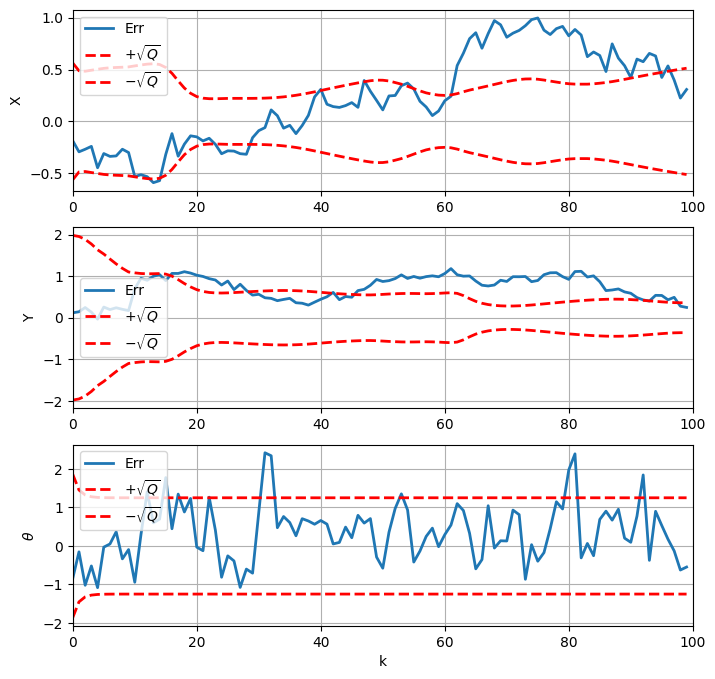

In [56]:
plt.figure(figsize=(8,8))
plt.subplot(311)
plt.plot(KK[0:N],Xsm[0,0,0:N]-Xstore[0,0,0:N],label=r'Err')
plt.plot(KK[0:N],np.sqrt(Qstore[0,0,:]),'r--',label=r'$+\sqrt{Q}$')
plt.plot(KK[0:N],-np.sqrt(Qstore[0,0,:]),'r--',label=r'$-\sqrt{Q}$')
plt.legend(loc='best')
plt.ylabel('X')
plt.xlim([0, N])
plt.grid(True)
plt.subplot(312)
plt.plot(KK[0:N],Xsm[1,0,0:N]-Xstore[1,0,0:N],label=r'Err')
plt.plot(KK[0:N],np.sqrt(Qstore[0,1,:]),'r--',label=r'$+\sqrt{Q}$')
plt.plot(KK[0:N],-np.sqrt(Qstore[0,1,:]),'r--',label=r'$-\sqrt{Q}$')
plt.legend(loc='best')
plt.xlim([0, N])
plt.ylabel('Y')
plt.grid(True)
#plt.tight_layout
plt.subplot(313)
plt.plot(KK[0:N],Xsm[2,0,0:N]/d2r - Xstore[2,0,0:N]/d2r,label=r'Err')
plt.plot(KK[0:N],np.sqrt(Qstore[0,2,:])/d2r,'r--',label=r'$+\sqrt{Q}$')
plt.plot(KK[0:N],-np.sqrt(Qstore[0,2,:])/d2r,'r--',label=r'$-\sqrt{Q}$')
plt.ylabel(r'$\theta$')
plt.legend(loc='best')
plt.xlim([0, N])
plt.xlabel('k')
plt.grid(True)
plt.show()
